### A/B TESTING

A/B Testing allows us to test two or more different ideas to see which one performs better.

It measures the impact of established KPIs. Therefore, KPI and exploratory data analysis (EDA) is important.

In this project, I will run an A/B test based on the retention KPI.

This is my take on the `Mobile Games A/B Testing with Cookie Cats` project on Datacamp.

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load the dataset
cookie_cats = pd.read_csv('cookie_cats.csv')
cookie_cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
cookie_cats.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

**DESCRIPTIVE STATISTICS**

In [5]:
cookie_cats.groupby('version').agg({'sum_gamerounds': ['count', 'mean', 'std', 'min', 'median', 'max'], 'userid': ['count'],
                                    'retention_1': [('True', lambda x: (x == True).sum()), ('False', lambda x: (x == False).sum())],
                                    'retention_7': [('True', lambda x: (x == True).sum()), ('False', lambda x: (x == False).sum())]})

sum_gamerounds                                          userid  \
                 count       mean         std min median    max  count   
version                                                                  
gate_30          44700  52.456264  256.716423   0     17  49854  44700   
gate_40          45489  51.298776  103.294416   0     16   2640  45489   

        retention_1        retention_7         
               True  False        True  False  
version                                        
gate_30       20034  24666        8502  36198  
gate_40       20119  25370        8279  37210

**OUTLIERS**

The `sum_gamerounds` feature will not be used. However, let's look at it visually since it is the only numerical variable.

I will use a simple boxplot to start.

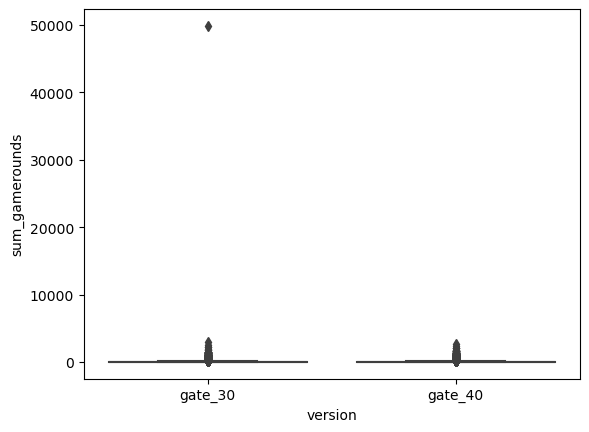

In [6]:
sns.boxplot(x=cookie_cats.version, y=cookie_cats.sum_gamerounds, data=cookie_cats);

It can be seen that there is an outlier. Let's remove that instance and plot again.

In [7]:
index = cookie_cats.loc[cookie_cats.sum_gamerounds > 10000].index.values
cookie_cats = cookie_cats.drop(index=index).reset_index().drop(columns=['index'])
cookie_cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


**DESCRIPTIVE STATISTICS - AFTER DELETING THE EXTREME VALUE**

After deleting the observation, the descriptive statistics of two groups look more similar.

In [8]:
cookie_cats.groupby('version').agg({'sum_gamerounds': ['count', 'mean', 'std', 'min', 'median', 'max'], 'userid': ['count'],
                                    'retention_1': [('True', lambda x: (x == True).sum()), ('False', lambda x: (x == False).sum())],
                                    'retention_7': [('True', lambda x: (x == True).sum()), ('False', lambda x: (x == False).sum())]})

sum_gamerounds                                         userid  \
                 count       mean         std min median   max  count   
version                                                                 
gate_30          44699  51.342111  102.057598   0     17  2961  44699   
gate_40          45489  51.298776  103.294416   0     16  2640  45489   

        retention_1        retention_7         
               True  False        True  False  
version                                        
gate_30       20034  24665        8501  36198  
gate_40       20119  25370        8279  37210

**EXPLORATORY DATA ANALYSIS**

**version**

This feature is our factor that contains the variants, i.e., gate_30 and gate_40.

It looks balanced.

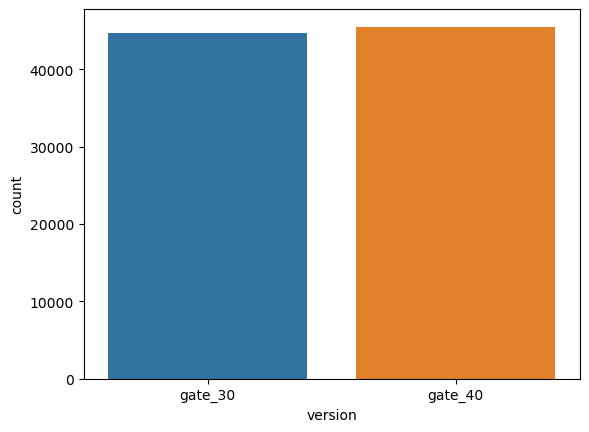

In [9]:
sns.countplot(data = cookie_cats, x = cookie_cats['version']);

**sum_gamerounds**

It can be from the graph that there are still higher values of `sum_gamerounds` that can be considered as outliers. Let's try log-transformation.

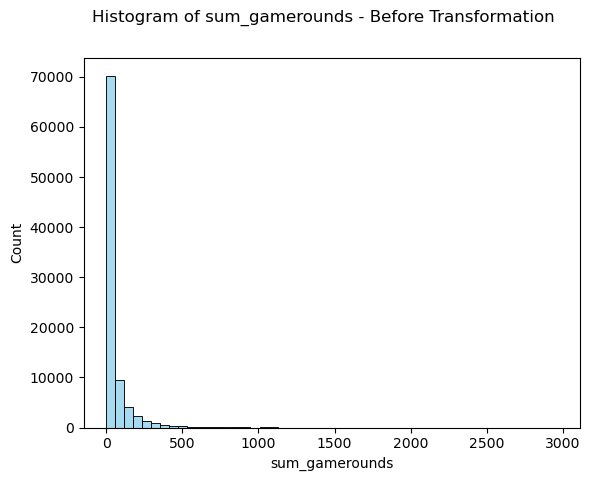

In [10]:
sns.histplot(cookie_cats.sum_gamerounds, bins=50, kde=False, color='skyblue', edgecolor='black');

plt.suptitle('Histogram of sum_gamerounds - Before Transformation')
plt.show()

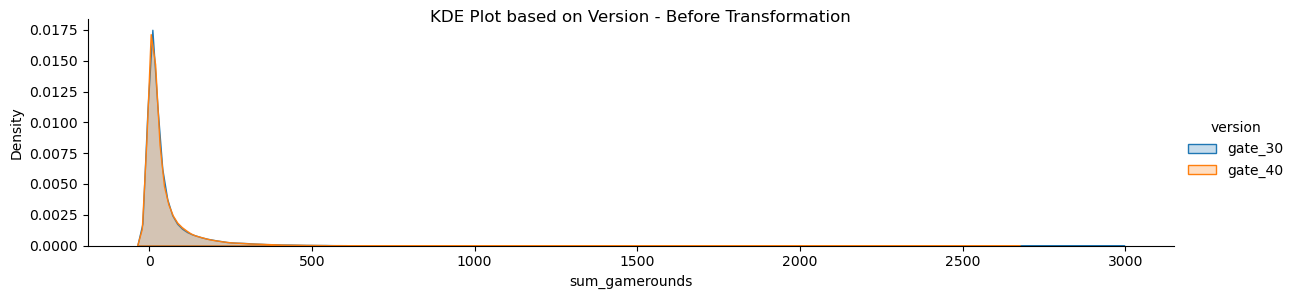

In [11]:
kde_plot = sns.FacetGrid(cookie_cats, hue = 'version', aspect= 4)
kde_plot.map(sns.kdeplot, 'sum_gamerounds', shade = True)
kde_plot.add_legend();

plt.suptitle('KDE Plot based on Version - Before Transformation')
plt.show()

After transformation, the histogram and distribution look much better.

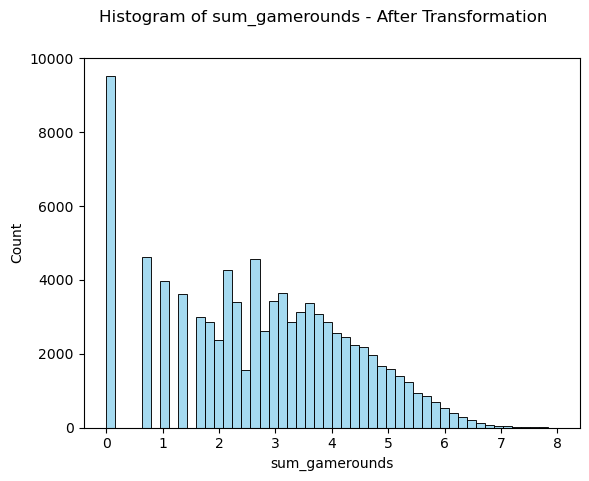

In [12]:
cookie_cats = cookie_cats.copy()
cookie_cats.sum_gamerounds = cookie_cats.sum_gamerounds.apply(lambda x: np.log(x) if x > 0 else 0)
sns.histplot(cookie_cats.sum_gamerounds, bins=50, kde=False, color='skyblue', edgecolor='black');

plt.suptitle('Histogram of sum_gamerounds - After Transformation')
plt.show()

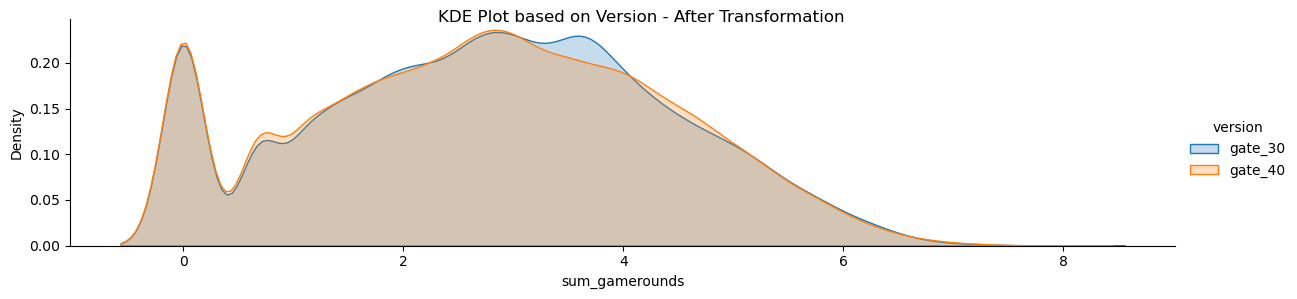

In [13]:
kde_plot = sns.FacetGrid(cookie_cats, hue = 'version', aspect= 4)
kde_plot.map(sns.kdeplot, 'sum_gamerounds', shade = True)
kde_plot.add_legend();

plt.suptitle('KDE Plot based on Version - After Transformation')
plt.show()

**retention_1**

The values of this feature look balanced based on the version feature.

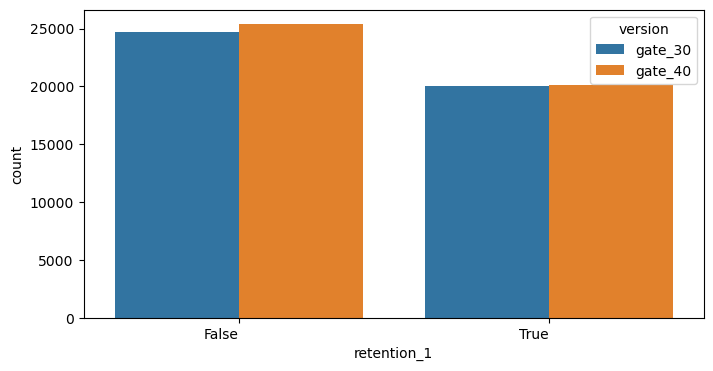

In [14]:
fig = plt.figure(figsize= (8,4))
ax = sns.countplot(x = cookie_cats.retention_1.astype('str'), hue = cookie_cats.version, data = cookie_cats)
ax.set_xticklabels(ax.get_xticklabels(), ha='right');

**retention_7**

The values of this feature also look balanced based on the version feature.

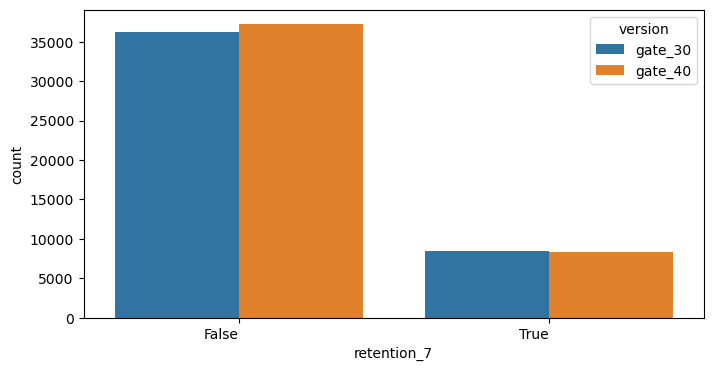

In [15]:
fig = plt.figure(figsize= (8,4))
ax = sns.countplot(x = cookie_cats.retention_7.astype('str'), hue = cookie_cats.version, data = cookie_cats)
ax.set_xticklabels(ax.get_xticklabels(), ha='right');

**OVERALL 1-DAY and 7-DAYS RETENTION**

In overall, the 1-day and 7-day retention are 44.52% abd 18.61%, respectively. Next, let's look at the these retention rates based on the variants.

Retention is calculated as the sum of the users that have come back and played the game, meaning that the retention feautures with `True` values, is divided by the total number of users.

In [16]:
overall_retention_1d = cookie_cats['retention_1'].sum() / cookie_cats['userid'].count()
overall_retention_7d = cookie_cats['retention_7'].sum() / cookie_cats['userid'].count()

print(f"{overall_retention_1d:.3%}", f"{overall_retention_7d:.3%}")

44.521% 18.606%


**1-DAY and 7-DAYS RETENTION BASED ON VERSION**

When I look at the result, I see that there is 0.6% difference between 1-Day retention.

Does this difference have an impact and is there possibility that making this change will produce negative outcomes in the future?

Both retention rates decrease when the gates are placed at level 40.

Also, 1-day retention rate is much higher than the 7-days retention, meaning that less people play the game after a week than after a day installing it.

In [17]:
overall_retention_version_1d = cookie_cats.groupby('version')['retention_1'].sum() / cookie_cats.groupby('version')['userid'].count()
overall_retention_version_7d = cookie_cats.groupby('version')['retention_7'].sum() / cookie_cats.groupby('version')['userid'].count()

overall_retention_version_1d = pd.DataFrame(overall_retention_version_1d, columns = ['retention_1_rate']).reset_index()
overall_retention_version_7d = pd.DataFrame(overall_retention_version_7d, columns = ['retention_7_rate']).reset_index()

overall_retention_version = overall_retention_version_1d.merge(overall_retention_version_7d, on=['version'], how='inner').set_index('version')
overall_retention_version

,retention_1_rate,retention_7_rate
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000


**A/B TESTING**

First, let check the normality assumptions and assess the homogeneity of variance assumption. For that, I will use `Shapiro-Wilk` and `Levene` tests to decide whether I need parametric or non-parametric tests, respectively.

95% is chosen as the confidence level.

And I will exclude the users who did not play.

In [34]:
cookie_cats.loc[(cookie_cats.sum_gamerounds != 0)].groupby('version').agg({'sum_gamerounds': ['count', 'mean', 'var', 'std']})

sum_gamerounds                             
                 count      mean       var      std
version                                            
gate_30          40013  3.088084  1.925961  1.38779
gate_40          40643  3.071800  1.967455  1.40266

In [31]:
#SHAPIRO-WILK TEST
sw_pvalue_game_30 = stats.shapiro(cookie_cats.loc[(cookie_cats.sum_gamerounds != 0) & (cookie_cats.version == 'gate_30')]['sum_gamerounds'])
sw_pvalue_game_40 = stats.shapiro(cookie_cats.loc[(cookie_cats.sum_gamerounds != 0) & (cookie_cats.version == 'gate_40')]['sum_gamerounds'])

print(sw_pvalue_game_30, sw_pvalue_game_40)

ShapiroResult(statistic=0.9827423691749573, pvalue=0.0) ShapiroResult(statistic=0.981216311454773, pvalue=0.0)


In [32]:
#LEVENE TEST
levene_pvalue = stats.levene(cookie_cats.loc[(cookie_cats.sum_gamerounds != 0) & (cookie_cats.version == 'gate_30')]['sum_gamerounds'],
                             cookie_cats.loc[(cookie_cats.sum_gamerounds != 0) & (cookie_cats.version == 'gate_40')]['sum_gamerounds'])
print(levene_pvalue)

LeveneResult(statistic=7.6019194628419875, pvalue=0.005831930546225711)


Based on the results below, I will move forward with a non-parametric test, namely Kolmogorov-Smirnov Test. Because the the distributions violates normality assumptions and he variances of different groups are significantly different under 95% confidence level.

- Shapiro-Wilk Test Result: 0.000
- Levene Test: 0.005

`Kolmogorov-Smirnov` test allows us to understand whether the distributions of two groups (game_30 and game_40 in this example) are statistically different from each other.

In [33]:
ks_pvalue = stats.ks_2samp(cookie_cats.loc[(cookie_cats.sum_gamerounds != 0) & (cookie_cats.version == 'gate_30')]['sum_gamerounds'],
                           cookie_cats.loc[(cookie_cats.sum_gamerounds != 0) & (cookie_cats.version == 'gate_40')]['sum_gamerounds'])
print(ks_pvalue)

KstestResult(statistic=0.010566422960492039, pvalue=0.022008449357239772)


Based on the result of Kolmogorov-Smirnov Test, I can conclude that A/B groups are **NOT SIMILAR** based on 95% confidence level.

- Kolmogorov-Smirnov Test: 0.022

**BOOTSTRAPPING FOR UNCERTAINTY**

I will repeatedly re-sample the dataset and calculate 1-day and 7-days retentions for these samples. The variation in 1-day and 7-days retention will give us an indication of how uncertain the retention rates are.

And then visualise with the density plot

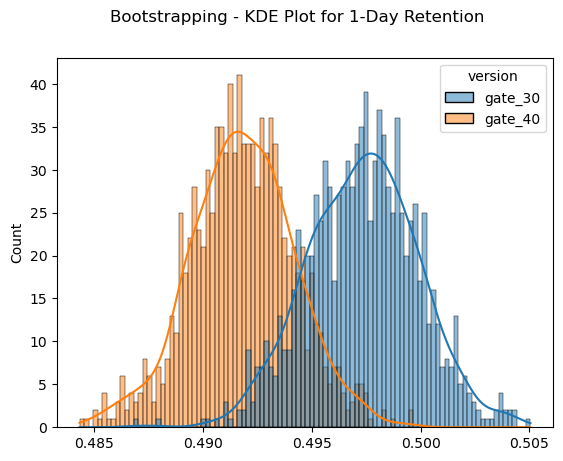

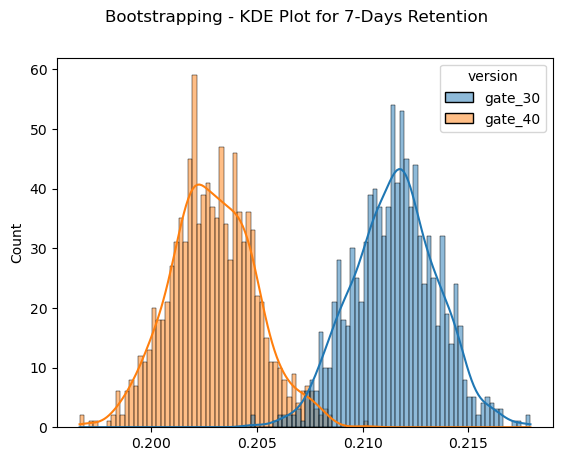

In [49]:
#Re-sampling with replacement
boot_1d = []
boot_7d = []

for i in range(1000):
    boot_1d_mean = cookie_cats.loc[(cookie_cats.sum_gamerounds != 0)].sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_7d_mean = cookie_cats.loc[(cookie_cats.sum_gamerounds != 0)].sample(frac=1, replace=True).groupby('version')['retention_7'].mean()

    boot_1d.append(boot_1d_mean)
    boot_7d.append(boot_7d_mean)

boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

sns.histplot(boot_1d, bins=100, kde=True, color='skyblue', edgecolor='black');
plt.suptitle('Bootstrapping - KDE Plot for 1-Day Retention')
plt.show()

sns.histplot(boot_7d, bins=100, kde=True, color='skyblue', edgecolor='black');
plt.suptitle('Bootstrapping - KDE Plot for 7-Days Retention')
plt.show()

**DIFFERENCE BETWEEN TWO A/B GROUPS**

Probability of the difference for 1-Day Retention: 94.40%
Probability of the difference for 7-Days Retention: 100.00%


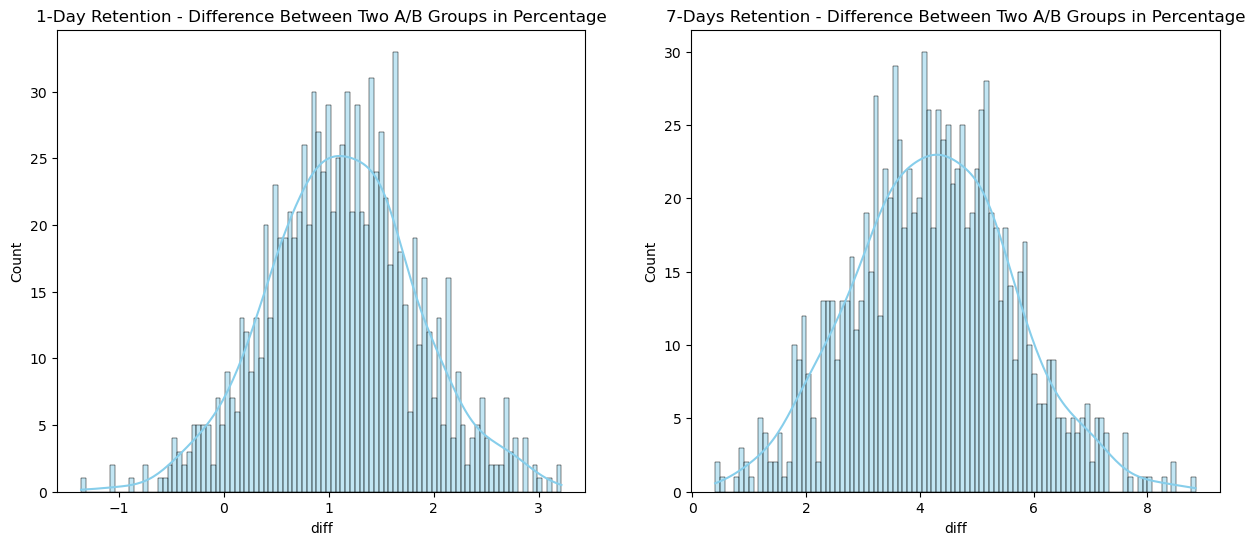

In [50]:
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40'])/boot_1d['gate_40']*100
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40'])/boot_7d['gate_40']*100

prob_1d = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])
prob_7d = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(f"Probability of the difference for 1-Day Retention: {prob_1d:.2%}")
print(f"Probability of the difference for 7-Days Retention: {prob_7d:.2%}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (15, 6))

sns.histplot(boot_1d['diff'], bins=100, kde=True, color='skyblue', edgecolor='black', ax=ax1);
sns.histplot(boot_7d['diff'], bins=100, kde=True, color='skyblue', edgecolor='black', ax=ax2);

ax1.set_title('1-Day Retention - Difference Between Two A/B Groups in Percentage')
ax2.set_title('7-Days Retention - Difference Between Two A/B Groups in Percentage')

plt.show()

**CONCLUSION**

After I look at all the results that I obtained, it can be concluded that although, the two groups are not similar based on the number of games played, the gates should not be placed at level 40. Because, the 7-Days Retention is higher when the gates are placed at 30.